# Diabetes Diagnose

In [1]:
using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

Functions for graphing typed Petri nets

In [2]:
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) =
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square",
                                     :color=>"black",
                                     :style=>"filled",
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) =
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle",
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext",
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) =
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle",
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)],
                                       :style=>"filled"))


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))
end

def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))

end

def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv),
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

diabetes_type = @stock_and_flow begin
    :stocks
    Pop

    :parameters
    rDeath
    rProgress
    rStrata

    :dynamic_variables
    v_death = rDeath * Pop
    v_progress = rProgress * Pop
    v_strata = rStrata * Pop

    :flows
    Pop => f_death(v_death) => CLOUD
    Pop => f_progress(v_progress) => Pop
    Pop => f_strata(v_strata) => Pop

    :sums
    N = [Pop]

end

GraphF(diabetes_type)

GraphF_typed(id(diabetes_type))

s, = parts(diabetes_type, :S)
sv, = parts(diabetes_type, :SV)
lsn, = parts(diabetes_type, :LS)
f_death, f_progress, f_strata = parts(diabetes_type, :F)
i_progress, i_strata = parts(diabetes_type, :I)
o_death, o_progress, o_strata = parts(diabetes_type, :O)
v_death, v_progress, v_strata = parts(diabetes_type, :V)
lv_death, lv_progress, lv_strata = parts(diabetes_type, :LV)
p_death, p_progress, p_strata = parts(diabetes_type, :P)
lpv_death, lpv_progress, lpv_strata = parts(diabetes_type, :LPV)

1:3

remove names to allow for the loose ACSet transform to be natural

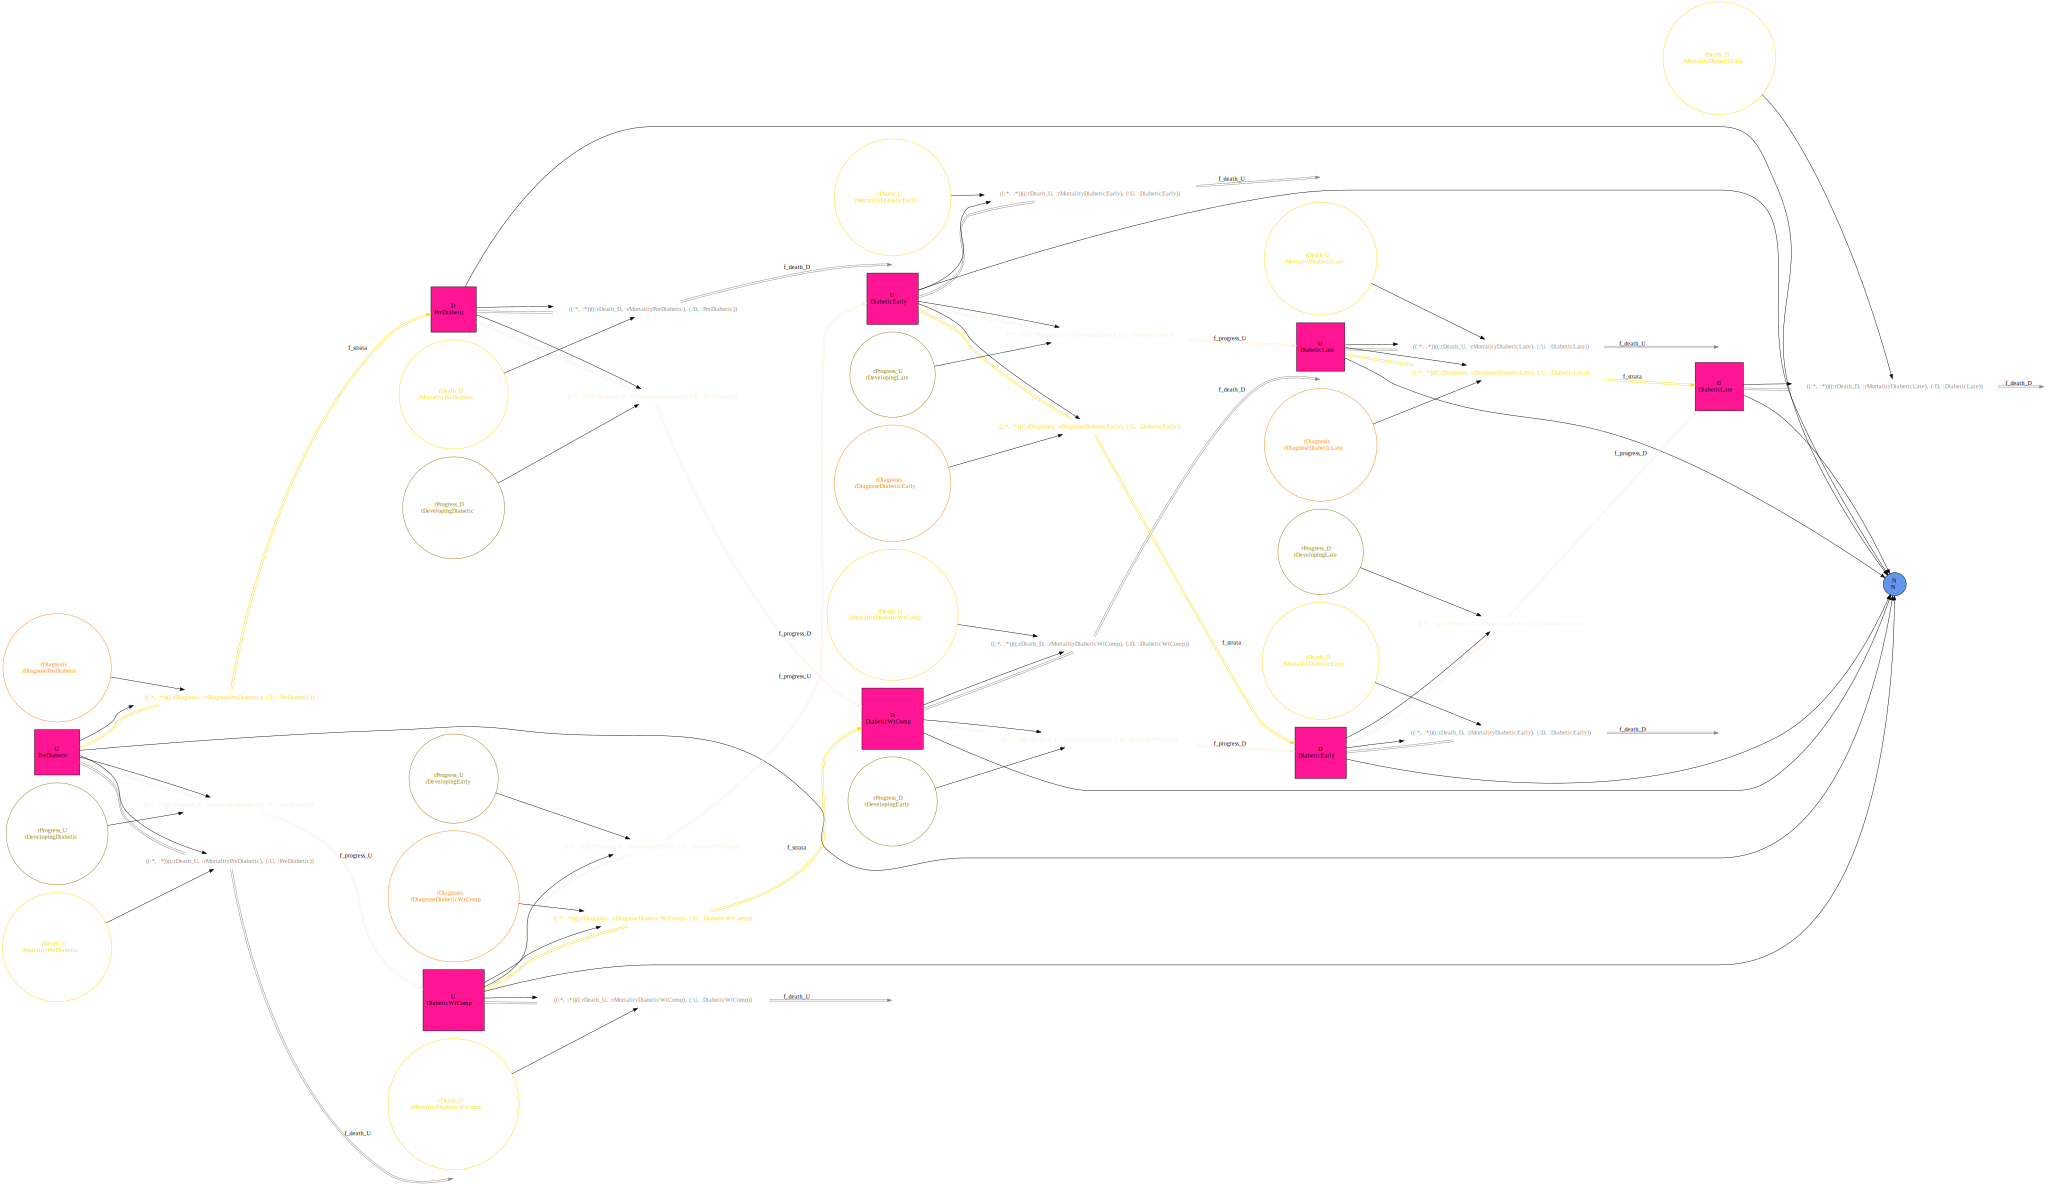

In [3]:
diabetes_type = map(diabetes_type, Name=name->nothing, Op = op -> nothing, Position = pos -> nothing);

diagnosis_strata = @stock_and_flow begin

    :stocks
    U
    D

    :dynamic_variables
    v_death_U = rDeath_U * U
    v_progress_U = rProgress_U * U
    v_death_D = rDeath_D * D
    v_progress_D = rProgress_D * D
    v_strata = rDiagnosis * U

    :parameters
    rDeath_U
    rProgress_U

    rDeath_D
    rProgress_D

    rDiagnosis



    :flows
    U => f_death_U(v_death_U) => CLOUD
    U => f_progress_U(v_progress_U) => U

    D => f_death_D(v_death_D) => CLOUD
    D => f_progress_D(v_progress_D) => D

    U => f_strata(v_strata) => D


    :sums
    N = [U, D]


end

GraphF(diagnosis_strata)

typed_diagnosis_strata=ACSetTransformation(diagnosis_strata, diabetes_type,
  S = [s, s],
  SV = [sv],
  LS = [lsn, lsn],
  F = [f_death, f_progress, f_death, f_progress, f_strata],
  I = [i_progress, i_progress, i_strata],
  O = [o_death, o_progress, o_strata, o_death, o_progress],
  V = [v_death, v_progress, v_death, v_progress, v_strata],
  LV = [lv_death, lv_progress, lv_death, lv_progress, lv_strata],
  P = [p_death, p_progress, p_death, p_progress, p_strata],
  LPV = [lpv_death, lpv_progress, lpv_death, lpv_progress, lpv_strata],
 Name=name->nothing, Op = op -> nothing, Position = pos -> nothing
)

@assert is_natural(typed_diagnosis_strata)

GraphF_typed(typed_diagnosis_strata)

diabetes_progress = @stock_and_flow begin
    :stocks
    PreDiabetic
    DiabeticWtComp
    DiabeticEarly
    DiabeticLate

    :parameters

    rDevelopingDiabetic
    rDevelopingEarly
    rDevelopingLate

    rMortalityPreDiabetic
    rMortalityDiabeticEarly
    rMortalityDiabeticLate
    rMortalityDiabeticWtComp


    rDiagnosePreDiabetic
    rDiagnoseDiabeticWtComp
    rDiagnoseDiabeticEarly
    rDiagnoseDiabeticLate

    :dynamic_variables
    v_DevelopingDiabetic = PreDiabetic * rDevelopingDiabetic
    v_DevelopingEarly = DiabeticWtComp * rDevelopingEarly
    v_DevelopingLate = DiabeticEarly * rDevelopingLate

    v_DeathPreDiabetic = PreDiabetic * rMortalityPreDiabetic
    v_DeathDiabeticWtComp = DiabeticWtComp * rMortalityDiabeticWtComp
    v_DeathDiabeticEarly = DiabeticEarly * rMortalityDiabeticEarly
    v_DeathDiabeticLate = DiabeticLate * rMortalityDiabeticLate

    v_DiagnosePreDiabetic = PreDiabetic * rDiagnosePreDiabetic
    v_DiagnoseDiabeticWtComp = DiabeticWtComp * rDiagnoseDiabeticWtComp
    v_DiagnoseDiabeticEarly = DiabeticEarly * rDiagnoseDiabeticEarly
    v_DiagnoseDiabeticLate = DiabeticLate * rDiagnoseDiabeticLate

    :flows
    PreDiabetic => f_DevelopingDiabetic(v_DevelopingDiabetic) => DiabeticWtComp
    PreDiabetic => f_DeathPreDiabetic(v_DeathPreDiabetic) => CLOUD
    DiabeticWtComp => f_DevelopingEarly(v_DevelopingEarly) => DiabeticEarly
    DiabeticWtComp => f_DeathDiabeticWtComp(v_DeathDiabeticWtComp) => CLOUD
    DiabeticEarly => f_DevelopingLate(v_DevelopingLate) => DiabeticLate
    DiabeticEarly => f_DeathDiabeticEarly(v_DeathDiabeticEarly) => CLOUD
    DiabeticLate => f_DeathDiabeticLate(v_DeathDiabeticLate) => CLOUD

    PreDiabetic => f_DiagnosePreDiabetic(v_DiagnosePreDiabetic) => PreDiabetic
    DiabeticWtComp => f_DiagnoseDiabeticWtComp(v_DiagnoseDiabeticWtComp) => DiabeticWtComp
    DiabeticEarly => f_DiagnoseDiabeticEarly(v_DiagnoseDiabeticEarly) => DiabeticEarly
    DiabeticLate => f_DiagnoseDiabeticLate(v_DiagnoseDiabeticLate) => DiabeticLate

    :sums
    N = [PreDiabetic, DiabeticWtComp, DiabeticEarly, DiabeticLate]

end

typed_diabetes_progress=ACSetTransformation(diabetes_progress, diabetes_type,
  S = [s, s, s, s],
  SV = [sv],
  LS = [lsn, lsn, lsn, lsn],
  F = [f_progress, f_death, f_progress, f_death, f_progress, f_death, f_death, f_strata, f_strata, f_strata, f_strata],
  I = [i_strata, i_progress, i_strata, i_progress, i_strata, i_progress, i_strata],
  O = [o_progress, o_death, o_strata, o_progress, o_death, o_strata, o_progress, o_death, o_strata, o_death, o_strata],
  V = [v_progress, v_progress, v_progress, v_death, v_death, v_death, v_death, v_strata, v_strata, v_strata, v_strata],
  P = [p_progress, p_progress, p_progress, p_death, p_death, p_death, p_death, p_strata, p_strata, p_strata, p_strata],
  LV = [lv_progress, lv_progress, lv_progress, lv_death, lv_death, lv_death, lv_death, lv_strata, lv_strata, lv_strata, lv_strata],
  LPV = [lpv_progress, lpv_progress, lpv_progress, lpv_death, lpv_death, lpv_death, lpv_death, lpv_strata, lpv_strata, lpv_strata, lpv_strata],
 Name=name->nothing, Op = op -> nothing, Position = pos -> nothing

)



@assert is_natural(typed_diabetes_progress)

GraphF_typed(typed_diabetes_progress)

strat_model = pullback(typed_diagnosis_strata, typed_diabetes_progress)
apex(strat_model)

stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2))

typed_stratify(typed_model1, typed_model2) =
  compose(proj1(pullback(typed_model1, typed_model2)), typed_model1);

typed_stratified_model = typed_stratify(typed_diagnosis_strata, typed_diabetes_progress)
GraphF_typed(typed_stratified_model)

to have the figures plotted fix to the wider of the cells

In [4]:
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")

HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")